![Car](download.gif)

GIF Credit : [california-dmv](california-dmv-9783.blogspot.com)

# AutoInland Vehicle Insurance Claim Using OverSampling and VotingClassifier 

This is a simple starter notebook to get started with the AutoInland Vehicle Insurance Claim Challenge on Zindi.

This notebook covers:
- Loading the data
- Simple EDA and an example of feature enginnering
- Data preprocessing and data wrangling
- Over Sampling
- Voting Classifier
- Making a submission
- Some tips for improving your score

This notebook is from Zindi Competition [AutoInland Vehicle Insurance Claim Challenge](https://zindi.africa/competitions/autoinland-vehicle-insurance-claim-challenge)

### Importing libraries

In [ ]:
import pandas as pd
import numpy as np
import datetime as dt
from tqdm.notebook import tqdm_notebook
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.linear_model import SGDClassifier
from sklearn.metrics import f1_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split

from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

import warnings
warnings.filterwarnings('ignore')

### Read files

In [ ]:
# Load files into a pandas dataframe
train = pd.read_csv('Data/Train.csv')
test = pd.read_csv('Data/Test.csv')
ss = pd.read_csv('Data/SampleSubmission.csv')

### Some basic EDA

In [ ]:
# Preview the first five rows of the train set
train.head()

,ID,Policy Start Date,Policy End Date,Gender,Age,First Transaction Date,No_Pol,Car_Category,Subject_Car_Colour,Subject_Car_Make,LGA_Name,State,ProductName,target
0,ID_0040R73,2010-05-14,2011-05-13,Male,30,2010-05-14,1,Saloon,Black,TOYOTA,NaN,NaN,Car Classic,0
1,ID_0046BNK,2010-11-29,2011-11-28,Female,79,2010-11-29,1,JEEP,Grey,TOYOTA,NaN,NaN,Car Classic,1
2,ID_005QMC3,2010-03-21,2011-03-20,Male,43,2010-03-21,1,Saloon,Red,TOYOTA,NaN,NaN,Car Classic,0
3,ID_0079OHW,2010-08-21,2011-08-20,Male,2,2010-08-21,1,NaN,NaN,NaN,NaN,NaN,CarSafe,0
4,ID_00BRP63,2010-08-29,2010-12-31,Entity,20,2010-08-29,3,NaN,NaN,NaN,Lagos,Lagos,Muuve,1


In [ ]:
# Preview the first five rows of the test set
test.head()

,ID,Policy Start Date,Policy End Date,Gender,Age,First Transaction Date,No_Pol,Car_Category,Subject_Car_Colour,Subject_Car_Make,LGA_Name,State,ProductName
0,ID_009D84L,2010-04-24,2011-03-27,NO GENDER,25,2010-04-24,1,NaN,As Attached,Iveco,Victoria Island,Lagos,CVTP
1,ID_01DO2EQ,2010-01-01,2010-12-31,NaN,120,2010-01-01,4,NaN,As Attached,TOYOTA,Victoria Island,Lagos,Muuve
2,ID_01QM0NU,2010-10-23,2011-10-22,Female,46,2010-10-23,1,NaN,NaN,Ford,Abuja Municipal,Abuja-Municipal,Car Classic
3,ID_024NJLZ,2010-10-14,2011-10-13,Male,32,2010-10-14,1,NaN,NaN,NaN,Kosofe,Benue,Car Classic
4,ID_02BYET3,2010-09-16,2010-12-31,NaN,120,2010-09-16,4,NaN,NaN,TOYOTA,Victoria Island,Lagos,Muuve


In [ ]:
# Preview the first five rows of the sample submission file
ss.head()

,ID,target
0,ID_009D84L,0
1,ID_01DO2EQ,0
2,ID_01QM0NU,0
3,ID_024NJLZ,0
4,ID_02BYET3,0


In [ ]:
# Check the shape of the train and test sets
print(f'The shape of the train set is: {train.shape}\nThe shape of the test set is: {test.shape}')

The shape of the train set is: (12079, 14)
The shape of the test set is: (5177, 13)


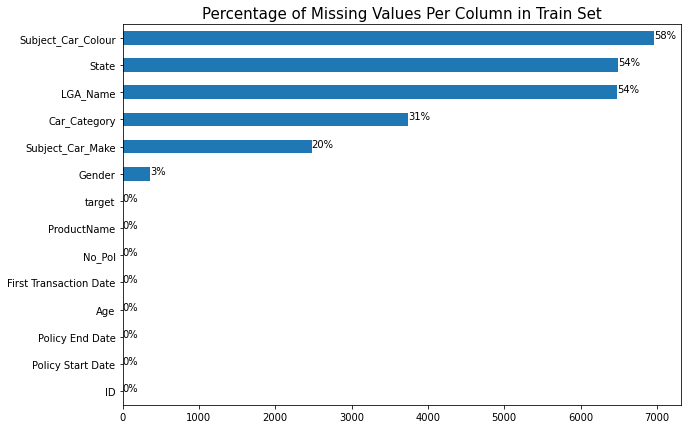

In [ ]:
# Check if there any missing values in train set
ax = train.isna().sum().sort_values().plot(kind = 'barh', figsize = (10, 7))
plt.title('Percentage of Missing Values Per Column in Train Set', fontdict={'size':15})
for p in ax.patches:
    percentage ='{:,.0f}%'.format((p.get_width()/train.shape[0])*100)
    width, height =p.get_width(),p.get_height()
    x=p.get_x()+width+0.02
    y=p.get_y()+height/2
    ax.annotate(percentage,(x,y))

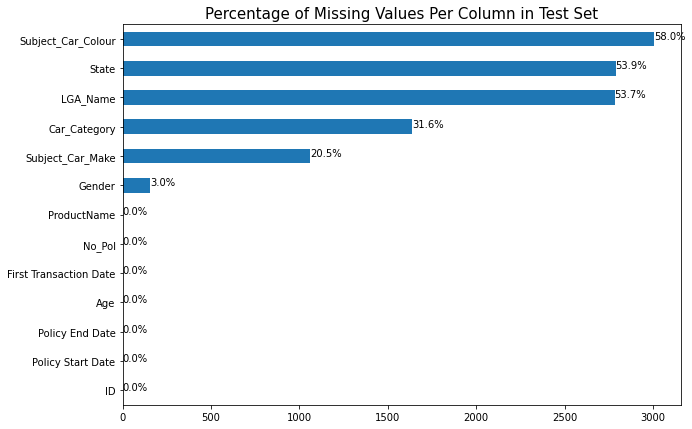

In [ ]:
# Check if there missing values in test set
ax = test.isna().sum().sort_values().plot(kind = 'barh', figsize = (10, 7))
plt.title('Percentage of Missing Values Per Column in Test Set', fontdict={'size':15})

for p in ax.patches:
    percentage ='{:,.1f}%'.format((p.get_width()/test.shape[0])*100)
    width, height =p.get_width(),p.get_height()
    x=p.get_x()+width+0.02
    y=p.get_y()+height/2
    ax.annotate(percentage,(x,y))

## Combine train and test set for easy preprocessing 

In [ ]:
# Combine train and test set
ntrain = train.shape[0] # to be used to split train and test set from the combined dataframe

all_data = pd.concat((train, test)).reset_index(drop=True)
print(f'The shape of the combined dataframe is: {all_data.shape}')

The shape of the combined dataframe is: (17256, 14)


In [ ]:
# Preview the last five rows of the combined dataframe
all_data.tail()

,ID,Policy Start Date,Policy End Date,Gender,Age,First Transaction Date,No_Pol,Car_Category,Subject_Car_Colour,Subject_Car_Make,LGA_Name,State,ProductName,target
17251,ID_ZYXX5AF,2010-07-18,2011-07-17,Male,48,2010-07-18,1,Saloon,NaN,Honda,NaN,NaN,CarSafe,NaN
17252,ID_ZYYOZ5L,2010-12-04,2011-12-03,NaN,50,2010-12-04,1,NaN,NaN,NaN,Victoria Island,Lagos,Car Classic,NaN
17253,ID_ZZ1GTKD,2010-09-24,2011-09-23,Male,1,2010-09-24,1,NaN,NaN,NaN,NaN,NaN,CarSafe,NaN
17254,ID_ZZDXQSI,2010-07-17,2011-07-16,Female,52,2010-07-17,1,Saloon,Grey,TOYOTA,NaN,NaN,Car Classic,NaN
17255,ID_ZZYTLV1,2010-07-17,2011-07-16,Male,68,2010-07-17,1,Saloon,NaN,Peugeot,NaN,NaN,CarSafe,NaN


In [ ]:
# Check the column names and datatypes
all_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17256 entries, 0 to 17255
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   ID                      17256 non-null  object 
 1   Policy Start Date       17256 non-null  object 
 2   Policy End Date         17256 non-null  object 
 3   Gender                  16741 non-null  object 
 4   Age                     17256 non-null  int64  
 5   First Transaction Date  17256 non-null  object 
 6   No_Pol                  17256 non-null  int64  
 7   Car_Category            11880 non-null  object 
 8   Subject_Car_Colour      7289 non-null   object 
 9   Subject_Car_Make        13719 non-null  object 
 10  LGA_Name                7998 non-null   object 
 11  State                   7980 non-null   object 
 12  ProductName             17256 non-null  object 
 13  target                  12079 non-null  float64
dtypes: float64(1), int64(2), object(11)
me

In [ ]:
# Change each column to its appriopriate datatype
date_cols = [col for col in all_data.columns if 'Date' in col]
num_cols = ['Age', 'No_Pol']
cat_cols = [col for col in all_data.columns if col not in date_cols+num_cols+['ID', 'target']]

for col in all_data.columns:
  if col in date_cols:
    all_data[col] = pd.to_datetime(all_data[col])
  elif col in cat_cols:
    all_data[col] = all_data[col].astype('category')

# Confirm whether the changes have been applied successfully
all_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17256 entries, 0 to 17255
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   ID                      17256 non-null  object        
 1   Policy Start Date       17256 non-null  datetime64[ns]
 2   Policy End Date         17256 non-null  datetime64[ns]
 3   Gender                  16741 non-null  category      
 4   Age                     17256 non-null  int64         
 5   First Transaction Date  17256 non-null  datetime64[ns]
 6   No_Pol                  17256 non-null  int64         
 7   Car_Category            11880 non-null  category      
 8   Subject_Car_Colour      7289 non-null   category      
 9   Subject_Car_Make        13719 non-null  category      
 10  LGA_Name                7998 non-null   category      
 11  State                   7980 non-null   category      
 12  ProductName             17256 non-null  catego

### Distribution of the target variable

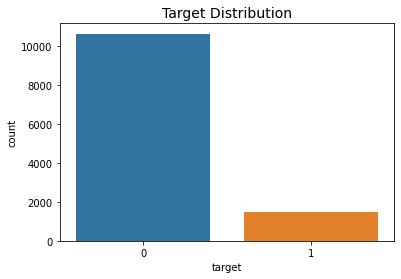

In [ ]:
sns.countplot(train.target)
plt.title('Target Distribution', fontdict={'size':14});

### Distribution of the Gender column

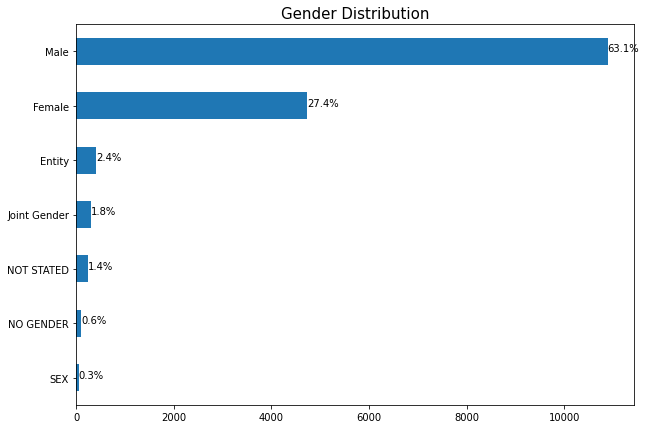

In [ ]:
# Gender distribution 
ax = all_data.Gender.value_counts().sort_values().plot(kind = 'barh', figsize=(10,7))
plt.title('Gender Distribution', fontdict={'size': 15})
for p in ax.patches:
  percentage ='{:,.1f}%'.format((p.get_width()/all_data.shape[0])*100)
  width, height =p.get_width(),p.get_height()
  x=p.get_x()+width+0.02
  y=p.get_y()+height/2
  ax.annotate(percentage,(x,y))

In [ ]:
mapper = {'Entity':'Other', 'Joint Gender':'Other', 'NOT STATED':'Other', 'NO GENDER': 'Other', 'SEX':"Other"}
all_data.Gender = all_data.Gender.replace(mapper)

# Confirm mappings
all_data.Gender.value_counts()

Male      10888
Female     4735
Other      1118
Name: Gender, dtype: int64

### Number of unique values per categorical column

In [ ]:
# Check unique values for each categorical column
for col in cat_cols:
  print(col)
  print(all_data[col].unique(), '\n')

Gender
['Male', 'Female', 'Other', NaN]
Categories (3, object): ['Male', 'Female', 'Other'] 

Car_Category
['Saloon', 'JEEP', NaN, 'Motorcycle', 'Truck', ..., 'Wagon', 'Shape Of Vehicle Chasis', 'Sedan', 'Station 4 Wheel', 'Tipper Truck']
Length: 17
Categories (16, object): ['Saloon', 'JEEP', 'Motorcycle', 'Truck', ..., 'Shape Of Vehicle Chasis', 'Sedan', 'Station 4 Wheel', 'Tipper Truck'] 

Subject_Car_Colour
['Black', 'Grey', 'Red', NaN, 'As Attached', ..., 'Yellow & White', 'Beige Mitalic', 'Light Gray', 'Blue Sky', 'Red Maroon']
Length: 47
Categories (46, object): ['Black', 'Grey', 'Red', 'As Attached', ..., 'Beige Mitalic', 'Light Gray', 'Blue Sky', 'Red Maroon'] 

Subject_Car_Make
['TOYOTA', NaN, 'REXTON', 'Lexus', 'Hyundai', ..., 'BRILLIANCE', 'Buik', 'COMMANDER', 'Bajaj', 'Datsun']
Length: 76
Categories (75, object): ['TOYOTA', 'REXTON', 'Lexus', 'Hyundai', ..., 'Buik', 'COMMANDER', 'Bajaj', 'Datsun'] 

LGA_Name
[NaN, 'Lagos', 'Ikeja', 'Badagry', 'Eti-Osa', ..., 'Hong', 'Ifako-

### Filling in missing values
#### Missing values can be filled using different strategies


In [ ]:
# Fill in missing values
# For cat cols and date cols fill in with mode and for num cols fill in with 9999
for col in all_data.columns:
  if col in date_cols+cat_cols:
    all_data[col] = all_data[col].fillna(all_data[col].mode()[0])
  elif col in num_cols:
    all_data[col] = all_data[col].fillna(all_data[col].fillna(9999))

# Confirm that there aren't any missing values
all_data[all_data.columns.difference(['target'])].isna().sum()

Age                       0
Car_Category              0
First Transaction Date    0
Gender                    0
ID                        0
LGA_Name                  0
No_Pol                    0
Policy End Date           0
Policy Start Date         0
ProductName               0
State                     0
Subject_Car_Colour        0
Subject_Car_Make          0
dtype: int64

### Feature Engineering
#### Alot of features can be extracted from dates

In [ ]:
# Extract date features from the date columns
for col in date_cols:
  for date_feature in ['year', 'month', 'day']:
    all_data[col+date_feature] = getattr(all_data[col].dt, date_feature)
# all_data = all_data.fillna(-999)
all_data.head()

,ID,Policy Start Date,Policy End Date,Gender,Age,First Transaction Date,No_Pol,Car_Category,Subject_Car_Colour,Subject_Car_Make,...,target,Policy Start Dateyear,Policy Start Datemonth,Policy Start Dateday,Policy End Dateyear,Policy End Datemonth,Policy End Dateday,First Transaction Dateyear,First Transaction Datemonth,First Transaction Dateday
0,ID_0040R73,2010-05-14,2011-05-13,Male,30,2010-05-14,1,Saloon,Black,TOYOTA,...,0.0,2010,5,14,2011,5,13,2010,5,14
1,ID_0046BNK,2010-11-29,2011-11-28,Female,79,2010-11-29,1,JEEP,Grey,TOYOTA,...,1.0,2010,11,29,2011,11,28,2010,11,29
2,ID_005QMC3,2010-03-21,2011-03-20,Male,43,2010-03-21,1,Saloon,Red,TOYOTA,...,0.0,2010,3,21,2011,3,20,2010,3,21
3,ID_0079OHW,2010-08-21,2011-08-20,Male,2,2010-08-21,1,Saloon,Black,TOYOTA,...,0.0,2010,8,21,2011,8,20,2010,8,21
4,ID_00BRP63,2010-08-29,2010-12-31,Other,20,2010-08-29,3,Saloon,Black,TOYOTA,...,1.0,2010,8,29,2010,12,31,2010,8,29


#### Try different strategies of dealing with categorical variables

In [ ]:
cat_cols

['Gender',
 'Car_Category',
 'Subject_Car_Colour',
 'Subject_Car_Make',
 'LGA_Name',
 'State',
 'ProductName']

In [ ]:
# Encode categorical features
all_data = pd.get_dummies(data = all_data, columns = cat_cols)
all_data.head()

,ID,Policy Start Date,Policy End Date,Age,First Transaction Date,No_Pol,target,Policy Start Dateyear,Policy Start Datemonth,Policy Start Dateday,...,State_Warri-South,ProductName_CVTP,ProductName_Car Classic,ProductName_Car Plus,ProductName_Car Vintage,ProductName_CarFlex,ProductName_CarSafe,ProductName_Customized Motor,ProductName_Motor Cycle,ProductName_Muuve
0,ID_0040R73,2010-05-14,2011-05-13,30,2010-05-14,1,0.0,2010,5,14,...,0,0,1,0,0,0,0,0,0,0
1,ID_0046BNK,2010-11-29,2011-11-28,79,2010-11-29,1,1.0,2010,11,29,...,0,0,1,0,0,0,0,0,0,0
2,ID_005QMC3,2010-03-21,2011-03-20,43,2010-03-21,1,0.0,2010,3,21,...,0,0,1,0,0,0,0,0,0,0
3,ID_0079OHW,2010-08-21,2011-08-20,2,2010-08-21,1,0.0,2010,8,21,...,0,0,0,0,0,0,1,0,0,0
4,ID_00BRP63,2010-08-29,2010-12-31,20,2010-08-29,3,1.0,2010,8,29,...,0,0,0,0,0,0,0,0,0,1


In [ ]:
# import re
# all_data = all_data.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))

In [ ]:
main_cols = all_data.columns.difference(date_cols+['ID', 'target'])

In [ ]:
# Separate train and test data from the combined dataframe
train_df = all_data[:ntrain]
test_df = all_data[ntrain:]

# Check the shapes of the split dataset
train_df.shape, test_df.shape

((12079, 548), (5177, 548))

### Training and making predictions



In [ ]:
train_df.columns

Index(['ID', 'Policy Start Date', 'Policy End Date', 'Age',
       'First Transaction Date', 'No_Pol', 'target', 'Policy Start Dateyear',
       'Policy Start Datemonth', 'Policy Start Dateday',
       ...
       'State_Warri-South', 'ProductName_CVTP', 'ProductName_Car Classic',
       'ProductName_Car Plus', 'ProductName_Car Vintage',
       'ProductName_CarFlex', 'ProductName_CarSafe',
       'ProductName_Customized Motor', 'ProductName_Motor Cycle',
       'ProductName_Muuve'],
      dtype='object', length=548)

# Over Sampling

In [ ]:
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import ADASYN, BorderlineSMOTE, RandomOverSampler, SMOTE

In [ ]:
# Select main columns to be used in training

X = train_df[main_cols].values
y = train_df.target

us = RandomUnderSampler(0.2)
os = RandomOverSampler(0.95, random_state=10)
print(X.shape, y.shape)
X, y = os.fit_resample(X, y)
print(X.shape, y.shape)

(12079, 543) (12079,)
(20716, 543) (20716,)


# Voting Classifier 

In [ ]:
# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3, random_state=42)

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
# Train model
model1 = CatBoostClassifier(iterations=220,od_type="Iter",l2_leaf_reg=5,
                           learning_rate=0.95,verbose=0,
                           depth=10)

# model2 = LogisticRegression(multi_class='multinomial', random_state=1)
model3 = RandomForestClassifier(n_estimators=400, random_state=1)
model4 = GaussianNB()
model5= LGBMClassifier(learning_rate=0.5,n_estimators=1000,num_leaves=120,n_jobs =4,min_child_samples= 14,
 min_child_weight= 10)
model6=XGBClassifier()
model = VotingClassifier(estimators=[('cat', model1),('lgbm',model5)], voting='hard')
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Check the f1 score of the model
print(f'F1 score on the X_test is: {f1_score(y_test, y_pred)}')

F1 score on the X_test is: 0.9462907544495196


#### [More on F1 Score](https://en.wikipedia.org/wiki/F-score)

### Making predictions of the test set and creating a submission file

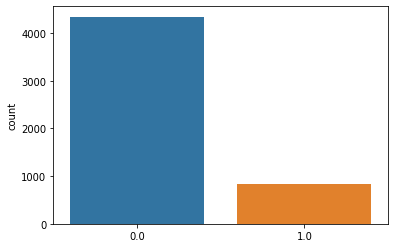

In [ ]:
# Make prediction on the test set
test_df = test_df[main_cols]
predictions = model.predict(test_df.values)

# Create a submission file
sub_file = ss.copy()
sub_file.predictions = predictions

# Check the distribution of your predictions
sns.countplot(sub_file.predictions);

In [ ]:
ss["target"] = predictions.astype("int")

In [ ]:
ss.to_csv("submission.csv",index=False)

In [ ]:
ss.head()

,ID,target
0,ID_009D84L,1
1,ID_01DO2EQ,1
2,ID_01QM0NU,0
3,ID_024NJLZ,0
4,ID_02BYET3,1


## This submission will easily get you into top 20 and if you want to win follow more tips.

![Picture title](image-20210406-162630.png)

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=fd06923d-6c6f-4386-b84b-713b5911f32f' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>